In [1]:
import pandas as pd
import sklearn

In [2]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn import svm

In [3]:
df = pd.read_csv('dataset_moyennes_matchs.csv')

### 1. Suppression des variables inutiles

In [4]:
# suppression des cotes et nb de goals dont on ne s'occupe pas pour le moment
df = df.drop(['FTHG','FTAG','B365H','B365D','B365A','LBH','LBD','LBA','PSH','PSD','PSA','WHH','WHD','WHA','VCH','VCD','VCA','PSCH','PSCD','PSCA'], axis=1)
# suppression de l'ancien idx
df = df.drop(['Unnamed: 0'], axis=1)
# suppression des variables informatives non nécessaires pour la modélisation
df = df.drop(['match_id','season','date','away_team_id','away_team_name','home_team_id','home_team_name'],axis=1)

### 2. Suppression des variables non significatives

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1425 entries, 0 to 1424
Data columns (total 60 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   home_team_rating               1425 non-null   float64
 1   home_won_contest               1425 non-null   float64
 2   home_possession_percentage     1425 non-null   float64
 3   home_total_throws              1425 non-null   float64
 4   home_blocked_scoring_att       1425 non-null   float64
 5   home_total_scoring_att         1425 non-null   float64
 6   home_total_tackle              1425 non-null   float64
 7   home_aerial_won                1425 non-null   float64
 8   home_aerial_lost               1425 non-null   float64
 9   home_accurate_pass             1425 non-null   float64
 10  home_total_pass                1425 non-null   float64
 11  home_won_corners               1425 non-null   float64
 12  home_shot_off_target           1425 non-null   f

- Etape préliminaire, remplacer les classes qui sont des lettres par des classes numériques (nécessaire pour la suite par exemple pour SVM)

In [6]:
df['FTR'] = df['FTR'].replace(['H','A','D'],[1,2,3])

- Création ensemble entraînement et test

In [36]:
target = df['FTR']
data = df.drop(['FTR'],axis=1)
# pour l'instant, séparation sur tout le jeu sans distinguer les périodes, voir si le module https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.TimeSeriesSplit.html serait pertinent ici
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.2)
scaler = preprocessing.StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

- Observation de la variance

-- pandas profiling

In [18]:
# test de l'outil pandas profiling
# ! pip install pandas-profiling
# (temps de traitement est long, à la fois pour la création de la variable report et pour la génération du fichier html, mais bcp plus rapide en json)
from pandas_profiling import ProfileReport
report = ProfileReport(df)
# le fichier html peut ensuite être ouvert pour afficher le rapport
# report.to_file("rapport_variables.html")


In [10]:
# report.to_file("your_report.json")

Export report to file: 100%|██████████| 1/1 [00:00<00:00,  6.03it/s]


In [29]:
# vérification dans le rapport des variables taggées avec "UNIQUE", "HIGH CARDINALITY", ou "UNIFORM", indicatrices d'une variance trop élevée
# Le rapport identifie away_pass comme "unique"
# "[UNIQUE] alert on column away_pass"
# étant donné que la variable home_pass n'est pas signalée, je ne supprime pas.
# vérification dans le rapport des variables taggées avec "CONSTANT", "REJECTED", "MISSING", "ZEROS" qui indiqueraient une variance trop faible
# home_post_scoring_att, away_total_offside, away_post_scoring_att ressortent avec le tag "zeros"
# pour l'instant non supprimées

-- variance threshold

In [9]:
from sklearn.feature_selection import VarianceThreshold

In [24]:
sel = VarianceThreshold(threshold = 1e-06)
sel.fit(X_train_scaled)

VarianceThreshold(threshold=1e-06)

In [25]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1425 entries, 0 to 1424
Data columns (total 59 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   home_team_rating               1425 non-null   float64
 1   home_won_contest               1425 non-null   float64
 2   home_possession_percentage     1425 non-null   float64
 3   home_total_throws              1425 non-null   float64
 4   home_blocked_scoring_att       1425 non-null   float64
 5   home_total_scoring_att         1425 non-null   float64
 6   home_total_tackle              1425 non-null   float64
 7   home_aerial_won                1425 non-null   float64
 8   home_aerial_lost               1425 non-null   float64
 9   home_accurate_pass             1425 non-null   float64
 10  home_total_pass                1425 non-null   float64
 11  home_won_corners               1425 non-null   float64
 12  home_shot_off_target           1425 non-null   f

In [26]:
mask = sel.get_support(indices=True)

In [27]:
# toutes les variables ont été retenues
mask

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58])

Les deux tests effectués ne semblent pas indiquer de nécessité de supprimer des features pour des raisons de variance dans ce cas.

- Correlation

Observation des corrélations linéaires pour voir quelles features semblent avoir un impact sur le résultat des matches

<AxesSubplot:>

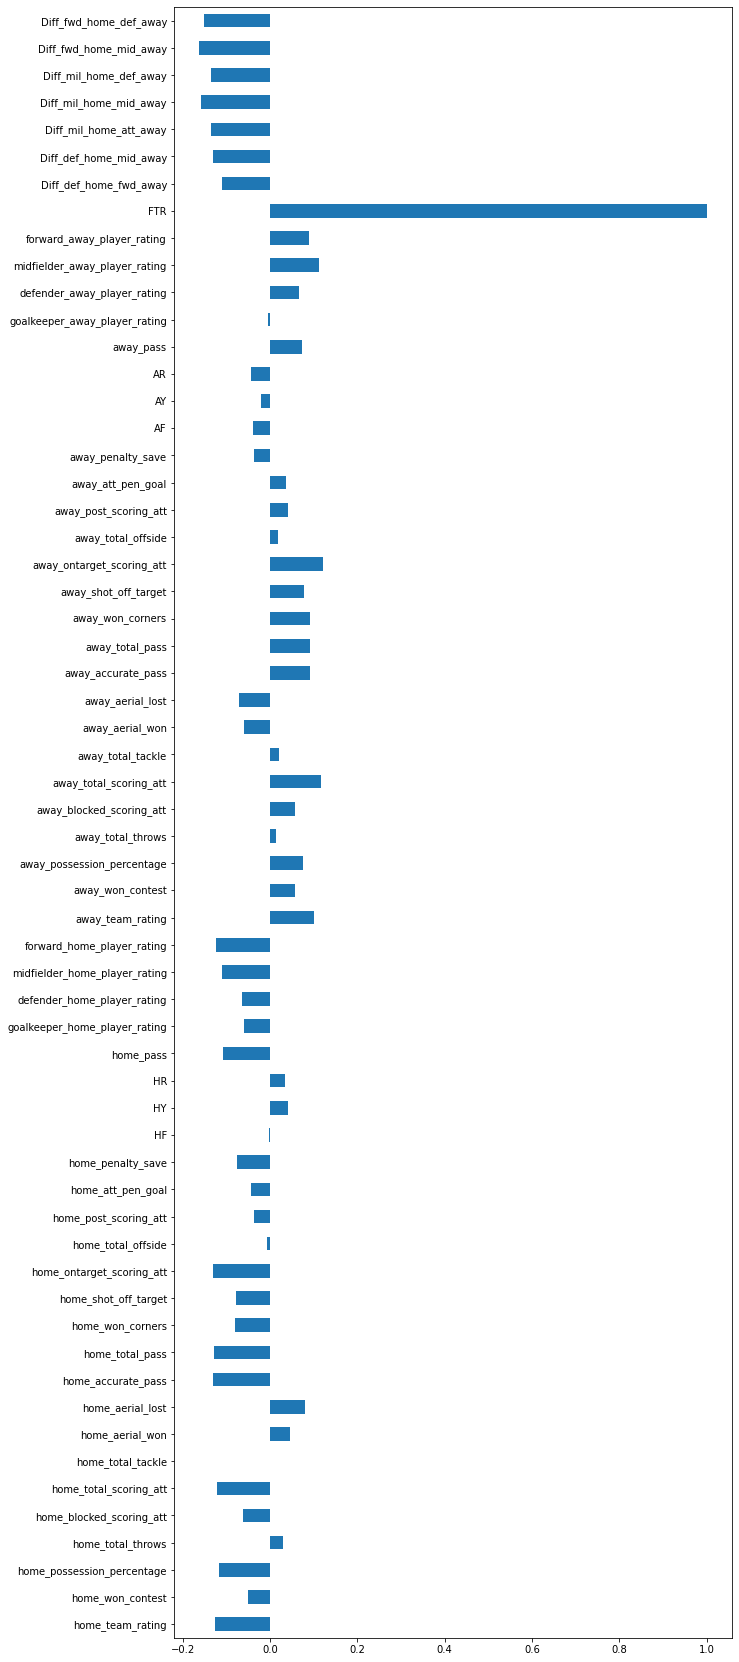

In [7]:
df.corr().loc['FTR'].plot(figsize=(10,30),kind='barh')

In [8]:
# corrélation Pearson

from scipy.stats import pearsonr
from pandas.api.types import is_numeric_dtype

for c in df.columns:
    if is_numeric_dtype(df[c]):
        correlation, pvalue = pearsonr(df[c], df['FTR'])
        print(f'{c : <40}: {correlation : .4f}, significant: {pvalue <= 0.05}')


home_team_rating                        : -0.1252, significant: True
home_won_contest                        : -0.0506, significant: False
home_possession_percentage              : -0.1171, significant: True
home_total_throws                       :  0.0298, significant: False
home_blocked_scoring_att                : -0.0605, significant: True
home_total_scoring_att                  : -0.1202, significant: True
home_total_tackle                       : -0.0006, significant: False
home_aerial_won                         :  0.0465, significant: False
home_aerial_lost                        :  0.0814, significant: True
home_accurate_pass                      : -0.1292, significant: True
home_total_pass                         : -0.1283, significant: True
home_won_corners                        : -0.0806, significant: True
home_shot_off_target                    : -0.0780, significant: True
home_ontarget_scoring_att               : -0.1313, significant: True
home_total_offside            

Les colonnes suivantes n'apparaissent pas comme ayant une corrélation significative:
home_won_contest (1),  home_total_throws (3), home_total_tackle (6), home_aerial_won (7), home_total_offside (14), home_post_scoring_att (15), home_att_pen_goal (16), HF (18), HY (19), HR (20)
away_total_throws (29), away_total_tackle (32), away_total_offside (40), away_post_scoring_att (41), away_att_pen_goal (42), away_penalty_save (43), AF (44), AY (45), AR (46), goalkeeper_away_player_rating (48)
Certaines reviennent à la fois dans home et away, d'autres pas
total_throws (3/29), total_tackle (6/32), total_offside (14/40), att_pen_goal (16/42), F (18/44), Y (19/45), R (20/46) semblent être sans corrélation significative au résultat

- Select K Best

In [20]:
from sklearn.feature_selection import SelectKBest, f_regression

In [28]:
sel_kbest = SelectKBest(score_func = f_regression, k=30)
sel_kbest.fit(X_train_scaled, y_train)

SelectKBest(k=30, score_func=<function f_regression at 0x7fee9e082670>)

In [29]:
mask = sel_kbest.get_support(indices=True)
mask

array([ 0,  2,  5,  8,  9, 10, 12, 13, 17, 21, 24, 25, 26, 31, 33, 34, 35,
       36, 37, 39, 47, 50, 51, 52, 53, 54, 55, 56, 57, 58])

On remarque que les variables total throws (3/29), total tackles (6/32), total offside (14/40), att pen goal (16/42), F (18/44), Y (19/45), R (20/46) identifiées précédemment comme sans corrélation significative, n'apparaissent pas non plus dans le top 30 avec k best, ces variables pourront donc sans doute être supprimées.
Les features considérées comme les plus importantes avec k best sont:<br>
0   home_team_rating<br>
2   home_possession_percentage<br>
5   home_total_scoring_att<br>
8   home_aerial_lost<br>
9   home_accurate_pass<br>
10  home_total_pass<br>
12  home_shot_off_target<br>
13  home_ontarget_scoring_att<br>
17  home_penalty_save<br>
21  home_pass <br>
24  midfielder_home_player_rating<br>
25  forward_home_player_rating<br>
26  away_team_rating<br>
31  away_total_scoring_att<br>
33  away_aerial_won<br>
34  away_aerial_lost<br>
35  away_accurate_pass<br>
36  away_total_pass<br>
37  away_won_corners <br>
39  away_ontarget_scoring_att<br>
47  away_pass<br>
50  midfielder_away_player_rating<br>
51  forward_away_player_rating<br>
52  Diff_def_home_fwd_away<br>
53  Diff_def_home_mid_away<br>
54  Diff_mil_home_att_away<br>
55  Diff_mil_home_mid_away<br>
56  Diff_mil_home_def_away<br>
57  Diff_fwd_home_mid_away<br>
58  Diff_fwd_home_def_away<br>

- Régression logistique pour évaluation des features (afin d'apporter un angle multivarié)

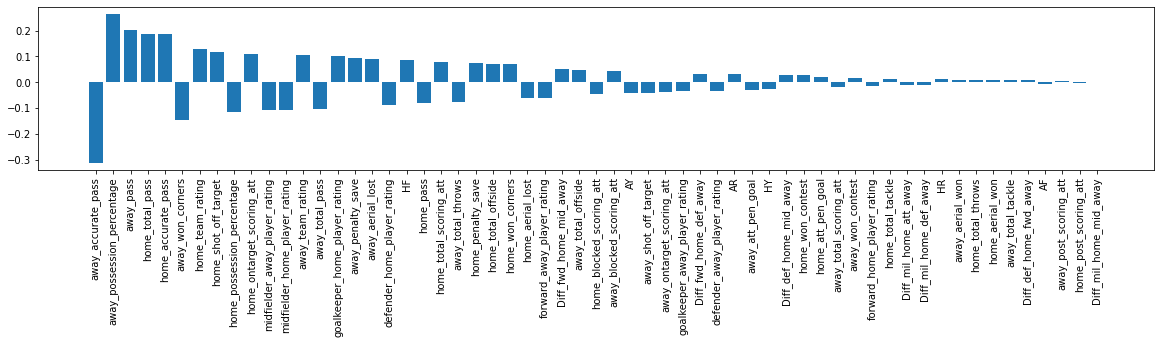

In [40]:
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
import numpy as np

lr = LogisticRegression(random_state=42, max_iter=1000, multi_class='multinomial')

lr.fit(X_train_scaled, y_train)

logit_coef = np.exp(lr.coef_[0]) - 1

idx = abs(logit_coef).argsort()[::-1]

plt.rcParams["figure.figsize"] = (20,3)

plt.bar(range(len(idx)), logit_coef[idx])
plt.xticks(range(len(idx)), data.columns[idx], rotation=90)

plt.show()

- PCA

In [85]:
from sklearn.decomposition import PCA
pca = PCA(n_components = 0.9, random_state=42)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)


#### 6. Modèles

In [111]:
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV

Recherche de modèles de classification multi-classes performants pour le jeu de données

- SVM

In [87]:
from sklearn.svm import SVC

In [104]:
# ajout d'un OneVsRestClassifier car les numéros des classes ne correspondent pas à un ordre spécifique
from sklearn.multiclass import OneVsRestClassifier
ovr_clf = OneVsRestClassifier(SVC(random_state=22))

In [105]:
ovr_clf.fit(X_train_pca,y_train)

OneVsRestClassifier(estimator=SVC(random_state=22))

In [106]:
y_pred = ovr_clf.predict(X_test_pca)

In [107]:
pd.crosstab(y_test,y_pred, rownames=['Classes réelles'], colnames=['Classes prédites'])

Classes prédites,1,2,3
Classes réelles,,,
1,98,26,8
2,41,43,2
3,39,26,2


In [108]:
accuracy = accuracy_score(y_test, y_pred)
print(accuracy)

0.5017543859649123


- SGD Classifier

In [93]:
from sklearn.linear_model import SGDClassifier

In [151]:
sgd_clf = SGDClassifier()

In [152]:
sgd_clf.fit(X_train_pca,y_train)

SGDClassifier()

In [153]:
y_pred = sgd_clf.predict(X_test_pca)

In [154]:
pd.crosstab(y_test,y_pred, rownames=['Classes réelles'], colnames=['Classes prédites'])

Classes prédites,1,2,3
Classes réelles,,,
1,71,31,30
2,46,31,9
3,39,22,6


In [155]:
accuracy = accuracy_score(y_test, y_pred)
print(accuracy)

0.37894736842105264


In [156]:
params = {
    "loss" : ["hinge", "log", "squared_hinge", "modified_huber"],
    "alpha" : [0.0001, 0.001, 0.01, 0.1],
    "penalty" : ["l2", "l1", "none"],
}

In [157]:
gridcv = GridSearchCV(sgd_clf, param_grid=params, scoring='accuracy', cv=3) 

In [158]:
gridcv.fit(X_train_pca, y_train)

pd.DataFrame(gridcv.cv_results_)[['params', 'mean_test_score', 'std_test_score']]

/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/Users/mariella.decrouychan/Documents/GitHub/Bookmakerspy/.venv/lib/python3.8/site-packages/sklearn/linear_model/_stochastic_gradient.py:696: Conver

,params,mean_test_score,std_test_score
0,"{'alpha': 0.0001, 'loss': 'hinge', 'penalty': ...",0.450877,0.022975
1,"{'alpha': 0.0001, 'loss': 'hinge', 'penalty': ...",0.436842,0.014090
2,"{'alpha': 0.0001, 'loss': 'hinge', 'penalty': ...",0.450000,0.024780
3,"{'alpha': 0.0001, 'loss': 'log', 'penalty': 'l2'}",0.425439,0.029799
4,"{'alpha': 0.0001, 'loss': 'log', 'penalty': 'l1'}",0.454386,0.013980
5,"{'alpha': 0.0001, 'loss': 'log', 'penalty': 'n...",0.442105,0.017055
6,"{'alpha': 0.0001, 'loss': 'squared_hinge', 'pe...",0.392982,0.037050
7,"{'alpha': 0.0001, 'loss': 'squared_hinge', 'pe...",0.405263,0.039386
8,"{'alpha': 0.0001, 'loss': 'squared_hinge', 'pe...",0.456140,0.011834
9,"{'alpha': 0.0001, 'loss': 'modified_huber', 'p...",0.436842,0.039210


In [161]:
print(gridcv.best_estimator_)
print(gridcv.best_score_)



SGDClassifier(alpha=0.01, loss='log', penalty='l1')
0.5149122807017544


- Random Forest

In [163]:
from sklearn import ensemble

In [164]:
clf_rf = ensemble.RandomForestClassifier(n_jobs=-1, random_state=321)
clf_rf.fit(X_train_pca, y_train)

RandomForestClassifier(n_jobs=-1, random_state=321)

In [167]:
y_pred = clf_rf.predict(X_test_pca)
pd.crosstab(y_test, y_pred, rownames=['Classe réelle'], colnames=['Classe prédite'])

Classe prédite,1,2,3
Classe réelle,,,
1,106,23,3
2,51,33,2
3,48,17,2


In [168]:
accuracy = accuracy_score(y_test, y_pred)
print(accuracy)

0.49473684210526314


In [169]:
param_grid_rf = [{'n_estimators': [10, 50, 100, 250, 500, 1000], 
                  'min_samples_leaf': [1, 3, 5], 
                  'max_features': ['sqrt', 'log2']}]

In [170]:
gridcv = GridSearchCV(clf_rf, param_grid=param_grid_rf, scoring='accuracy', cv=3) 

In [171]:
gridcv.fit(X_train_pca, y_train)

pd.DataFrame(gridcv.cv_results_)[['params', 'mean_test_score', 'std_test_score']]

,params,mean_test_score,std_test_score
0,"{'max_features': 'sqrt', 'min_samples_leaf': 1...",0.407895,0.019693
1,"{'max_features': 'sqrt', 'min_samples_leaf': 1...",0.478070,0.010154
2,"{'max_features': 'sqrt', 'min_samples_leaf': 1...",0.500877,0.010815
3,"{'max_features': 'sqrt', 'min_samples_leaf': 1...",0.496491,0.016127
4,"{'max_features': 'sqrt', 'min_samples_leaf': 1...",0.504386,0.011834
5,"{'max_features': 'sqrt', 'min_samples_leaf': 1...",0.506140,0.006564
6,"{'max_features': 'sqrt', 'min_samples_leaf': 3...",0.458772,0.017891
7,"{'max_features': 'sqrt', 'min_samples_leaf': 3...",0.486842,0.009846
8,"{'max_features': 'sqrt', 'min_samples_leaf': 3...",0.486842,0.013070
9,"{'max_features': 'sqrt', 'min_samples_leaf': 3...",0.495614,0.004962


In [172]:
print(gridcv.best_estimator_)
print(gridcv.best_score_)

RandomForestClassifier(max_features='log2', min_samples_leaf=5,
                       n_estimators=1000, n_jobs=-1, random_state=321)
0.5096491228070176
